# Multi-Class Multi-Label text Classification with Spacy

We are going to use the dataframe created in the previous notebook and use Spacy to create a model. <br>
Use one of the following to install the package: <br>
* conda install -c conda-forge spacy
* pip install -U spacy

To download one of the pre-trained models:
* python -m spacy download en_core_web_md

Loading general libraries....

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,skmultilearn,spacy -g

import os
import sys
import re
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
import random
import json
import watermark
from pprint import pprint as pp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas.plotting import register_matplotlib_converters    # for pandas_profiling

register_matplotlib_converters()                              # for pandas_profiling
sys.path.append(os.pardir)

CPython 3.7.3
IPython 7.8.0

numpy 1.16.4
pandas 0.25.0
skmultilearn not installed
spacy 2.0.16

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
Git hash   : b60f9edf55f3d414bbd7c746001deefe1e20d78f


As well as the specific libraries that we are going to use....

In [2]:
from src.nlp_func import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import spacy
from spacy.lang.en import English
from spacy.util import minibatch, compounding

ModuleNotFoundError: No module named 'textblob'

Load or install and load the pre-trained model for English language:

In [3]:
try:
    import en_core_web_md
except ImportError:
    import os

    os.system("python -m spacy download en_core_web_md")
    import en_core_web_md

### Constants

In [4]:
INPUT_DATA = "./data/processed/reuters.csv"
CATEGORIES_DATA = "./data/processed/reuters_categories.csv"
CLS_Model1 = "./models/Spacy_cls_01.csv"
CLS_Model2 = "./models/Spacy_cls_02.csv"

### Load the dataset

In [5]:
df = pd.read_csv(INPUT_DATA)
df['categories'] = df.categories.apply(json.loads)
df_categories = pd.read_csv(CATEGORIES_DATA)

Observe that we have the data we expected:

In [6]:
df.head(3)

,doc_Id,text,categories,doc_set,processed_text,lematized,n_words
0,test/14826,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,[trade],test,asian exporters fear damage united states japa...,asian exporters fear damage unite state japan ...,477
1,test/14828,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,[grain],test,china daily says vermin eat percentage grain s...,china daily say vermin eat percentage grain st...,64
2,test/14829,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,"[crude, nat-gas]",test,japan revise long term energy demand downwards...,japan revise long term energy demand downwards...,114


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10788 entries, 0 to 10787
Data columns (total 7 columns):
doc_Id            10788 non-null object
text              10788 non-null object
categories        10788 non-null object
doc_set           10788 non-null object
processed_text    10788 non-null object
lematized         10788 non-null object
n_words           10788 non-null int64
dtypes: int64(1), object(6)
memory usage: 590.0+ KB


In [8]:
df.describe()

,n_words
count,10788.000000
mean,81.630979
std,81.450745
min,2.000000
25%,32.000000
50%,55.000000
75%,99.000000
max,888.000000


As we have already analysed the documents in the previous stage, let's use the new model to create a classifier.

## Classifier Model

The 'en_core_web_md' model is a pre-trained model of medium size that we can download and comes with many features build-in

In [9]:
def apply_textcat_to_model(model, set_of_categories):
    # Add the text classifier to the pipeline if it doesn't exist
    if "textcat" not in model.pipe_names:
        # model.create_pipe works for built-ins that are registered with spaCy
        textcat = model.create_pipe(
                "textcat",
                config={
                    "choise_stype": 'multiple',
                    "exclusive_classes": False,
                    "architecture": "simple_cnn"}
        )
        model.add_pipe(textcat, last=True)

    # otherwise get it to add labels to it
    else:
        textcat = model.get_pipe("textcat")

    # Add the list of labels of the classifier
    for cat in tqdm(set_of_categories):
        textcat.add_label(cat)
    return model, textcat


# Load existing spacy model
nlp = spacy.load('en_core_web_md')

all_categories = df_categories.categories.unique()

# Add the text categories to the model
nlp, textcat = apply_textcat_to_model(nlp, all_categories)

In [10]:
# Create list of training data pairing it with the corresponding labels
X_all_packed = list(zip(df.lematized.tolist(), df.categories.tolist()))
label_list = df_categories.categories.unique().tolist()

# Now we need to transform the labels into a dictionary of labels with values True or False
def unpack_labels(data):
    training_data = []
    
    for eg in data:
        text = eg[0]
        accepted = eg[1]
        
        if not isinstance(text, str):
            raise TypeError('The doc must be a string')
        if not isinstance(accepted, list):
            raise TypeError('The accepted labels must be a list')
            
        # dictionary of all labels – if label is in accepted list, value is
        # set to True, otherwise it's set to False
        cats = {label: label in accepted for label in label_list}
        training_data.append((text, {'cats': cats}))
    
    return training_data

X_all = unpack_labels(X_all_packed)

In [11]:
X_train, X_test = train_test_split(X_all, test_size=0.2, random_state=42)
X_eval_doc, X_eval_cat = map(list, zip(*X_test))

We create as well a function to evaluate the progress of the model during training:

In [12]:
def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]['cats']
        for label, score in doc.cats.items():
            if label not in gold:
                continue

            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
                
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
        
    return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}

In [13]:
# Get the list of other pipes to disable them during the training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]

N_ITER = 10

with nlp.disable_pipes(*other_pipes):                              # only train TEXTCAT
    optimizer = nlp.begin_training()
    batch_sizes = compounding(4.0, 32.0, 1.001)
    print('Training the model...')
    print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "P", "R", "F"))

    for itn in tqdm(range(N_ITER)):
        losses = {}
        random.shuffle(X_train)
        batches = minibatch(X_train, size=batch_sizes)                  # batch of the set
        
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
        
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, X_eval_doc, X_eval_cat)
            print("{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(         # print a simple table
                losses["textcat"],
                scores["textcat_p"],
                scores["textcat_r"],
                scores["textcat_f"],
            ))

Training the model...
LOSS 	  P  	  R  	  F  


43.149	0.964	0.450	0.613
1.288	0.959	0.491	0.650
0.288	0.946	0.561	0.704
0.123	0.948	0.604	0.738
0.112	0.933	0.654	0.769
0.107	0.933	0.679	0.786
0.101	0.929	0.691	0.792
0.095	0.927	0.697	0.795
0.090	0.927	0.707	0.802
0.086	0.929	0.713	0.807



Now we test the resulting model:

In [14]:
def format_categories(cat, threshold=0.5):
    output = []
    for key, val in cat.items():
        if val > threshold:
            output.append(key + '(' + str(round(float(val), 2)) + ')')
    return output

test_text = X_eval_doc[:10]
cats = X_eval_cat[:10]
test_cats = [k['cats'] for k in cats]
counter = 1

for text, cat in zip(test_text, test_cats):
    print('Document {}'.format(counter))
    doc = nlp(text)
    print('\tPredicted categories: {}\n\tExpected categories: {}'.format(
        format_categories(doc.cats), 
        format_categories(cat)))
    counter += 1

Document 1
	Predicted categories: ['earn(1.0)']
	Expected categories: ['earn(1.0)']
Document 2
	Predicted categories: ['earn(1.0)']
	Expected categories: ['earn(1.0)']
Document 3
	Predicted categories: ['earn(1.0)']
	Expected categories: ['earn(1.0)']
Document 4
	Predicted categories: ['crude(1.0)', 'ship(0.99)']
	Expected categories: ['ship(1.0)']
Document 5
	Predicted categories: ['earn(1.0)']
	Expected categories: ['earn(1.0)']
Document 6
	Predicted categories: ['earn(1.0)']
	Expected categories: ['earn(1.0)']
Document 7
	Predicted categories: ['money-fx(0.6)', 'money-supply(0.65)']
	Expected categories: ['reserves(1.0)']
Document 8
	Predicted categories: ['acq(1.0)']
	Expected categories: ['acq(1.0)']
Document 9
	Predicted categories: ['earn(1.0)']
	Expected categories: ['earn(1.0)']
Document 10
	Predicted categories: ['acq(1.0)']
	Expected categories: ['acq(1.0)']


In [15]:
# Rename and save model to disk
nlp_clf1 = nlp
nlp_clf1.to_disk(CLS_Model1)

## Full Spacy Model

In the previous model we have made use of the existing processed data but we can use spacy to do the processing from the raw entries to evaluate if the stopwords and other elements have a better implementation.

In [16]:
# We could use 'nlp = English()' for the basic model as well
nlp = spacy.load('en_core_web_md')  
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In this ocasion we are going to define a transformer to perform the cleaning operations

In [17]:
# Custom transformer
class TextProcessing(BaseEstimator, TransformerMixin):
    def __init__(self, model, text_field='text', cat_field='categories'):
        self.model = model
        self.text_field = text_field
        self.cat_field = cat_field

    def fit(self, X, y=None, **fit_params):
        return self
        
    def transform(self, X, y=None, **transform_params):
        output = pd.DataFrame()
        output[self.cat_field] = X[self.cat_field]
        
        # Apply common cleaning operations
        cleaned = X[self.text_field].apply(text_replacements)
        cleaned = cleaned.apply(remove_accents)
        cleaned = cleaned.apply(remove_special)
        cleaned = cleaned.apply(remove_accents)
        # Remove stopwords and apply lemmatization
        output[self.text_field] = [' '.join(
            [word.lemma_ for word in self.model(text) if word.is_stop == False]) 
                  for text in cleaned]
        return output

    def get_params(self, deep=True):
        return {}

# Ex to create the pipeline object:    data_pipeline = TextProcessing(nlp, 'text', 'categories')

Create train and test datasets

In [18]:
X_tr, X_te = train_test_split(df, test_size=0.2, random_state=42)
tp = TextProcessing(nlp, 'text', 'categories')
x_te = tp.transform(X_te)

In [19]:
class Classifier(BaseEstimator, TransformerMixin):
    def __init__(self, model, n, textf='text', labelf='categories'):
        if model is None:
            self.model = spacy.load('en_core_web_md')
        else:
            self.model = model
        self.n = n                        # Number of iterations
        self.textf = textf
        self.labelf = labelf

    def fit(self, X, y=None, **fit_params):
        self.model, textcat = apply_textcat_to_model(self.model, all_categories)
        other_pipes = [pipe for pipe in self.model.pipe_names if pipe != "textcat"]
        
        # Transform the dataset into a list of tuples (doc-labels)
        X_all_packed = list(zip(X[self.textf].tolist(), X[self.labelf].tolist()))
        # Define the labels as a dictionary ready for spacy to use
        X = unpack_labels(X_all_packed)
        
        if y is not None:
            y = list(zip(y[self.textf].tolist(), y[self.labelf].tolist()))
            y = unpack_labels(y)
            y_doc, y_cat = map(list, zip(*y))
        
        with self.model.disable_pipes(*other_pipes):                            # only train TEXTCAT
            optimizer = self.model.begin_training()
            batch_sizes = compounding(4.0, 32.0, 1.001)
            print('Training the model...')
            print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "P", "R", "F"))

            for itn in tqdm(range(self.n)):
                losses = {}
                random.shuffle(X)
                batches = minibatch(X, size=batch_sizes)                        # batch of the set

                for batch in batches:
                    texts, annotations = zip(*batch)
                    self.model.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
                
                if y is not None:
                    with textcat.model.use_params(optimizer.averages):
                        # evaluate on the dev data split off in load_data()
                        scores = evaluate(self.model.tokenizer, textcat, y_doc, y_cat)
                        print("{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(         # print a simple table
                            losses["textcat"],
                            scores["textcat_p"],
                            scores["textcat_r"],
                            scores["textcat_f"],
                        ))
        
        return self
        
    def transform(self, X, **transform_params):
        return X[self.textf].apply(nlp)
        
    def predict(self, X, **transform_params):
        docs = X[self.textf].apply(nlp)
        return docs.apply(lambda x: x.cats)

    def get_params(self, deep=True):
        return {}

In [20]:
# Create pipeline with the data transformation and the classifier model
# nlp = spacy.load('en_core_web_md')

spacy_clf = Pipeline([
    ('cleaning', TextProcessing(nlp, 'text', 'categories')),
    ('clf', Classifier(None, 10, textf='text', labelf='categories')),
])

Train the model and obtain the scores while training:

In [21]:
spacy_clf.fit(X_tr, x_te)


Training the model...
LOSS 	  P  	  R  	  F  


36.317	0.952	0.483	0.641
1.239	0.947	0.534	0.683
0.263	0.940	0.598	0.731
0.120	0.934	0.643	0.762
0.113	0.929	0.667	0.776
0.106	0.930	0.684	0.788
0.102	0.930	0.689	0.791
0.096	0.931	0.695	0.796
0.093	0.932	0.702	0.801
0.089	0.932	0.710	0.806



Pipeline(memory=None,
         steps=[('cleaning', TextProcessing()), ('clf', Classifier())],
         verbose=False)

In [22]:
nlp.to_disk(CLS_Model2)

## Model Evaluation

As in the previous exercise we are going to plot the confusion matrix as well as other relevant information of the model.

In [23]:
def apply_threshold(predictions, threshold=0.5, report_value=False):
    """Filter predicted labels that are greater than the set threshold"""
    selected_labels = list(filter(lambda x: predictions[x] >= threshold, predictions.keys()))
    
    if report_value:
        return [(k, predictions[k]) for k in selected_labels]
    else:
        return selected_labels

In [24]:
te_pred = [nlp(doc) for doc in x_te['text'].tolist()]
pd_comp = pd.DataFrame({'actual': x_te['categories'], 'predicted': te_pred})
pd_comp['predicted'] = pd_comp['predicted'].apply(apply_threshold)

In [25]:
def unpacking(row, actual, predicted):
    unpack_found = []
    unpack_missing = []
    pred = row[predicted].copy()
    for m in row[actual]:
        if m in pred:
            pred.remove(m)
            unpack_found.append((m, m))
        else:
            unpack_missing.append((m, 'unknown'))
    
    n_pred = len(pred)
    if n_pred == 1:
        for i, m in enumerate(unpack_missing):
            unpack_missing[i] = (m[0], pred[0])
    elif (n_pred > 1) and (n_pred < len(unpack_missing)):
        for i, m in enumerate(pred):
            unpack_missing[i] = (m[0], pred[i])
    elif (n_pred > 1) and (n_pred > len(unpack_missing)):
        for i, m in enumerate(unpack_missing):
            unpack_missing[i] = (m[0], pred[i])
    unpack_found.extend(unpack_missing)
    return unpack_found

In [26]:
unpack_labels = []

# Get the pairs of category-prediction
pairs_df = pd_comp.apply(lambda row: unpacking(row, 'actual', 'predicted'), axis=1)
# Flatten the list of lists
flat_pairs = [item for sublist in pairs_df.values for item in sublist]
# Create dataframe
df_flat = pd.DataFrame(flat_pairs, columns=['actual', 'predicted'])

### Confusion Matrix

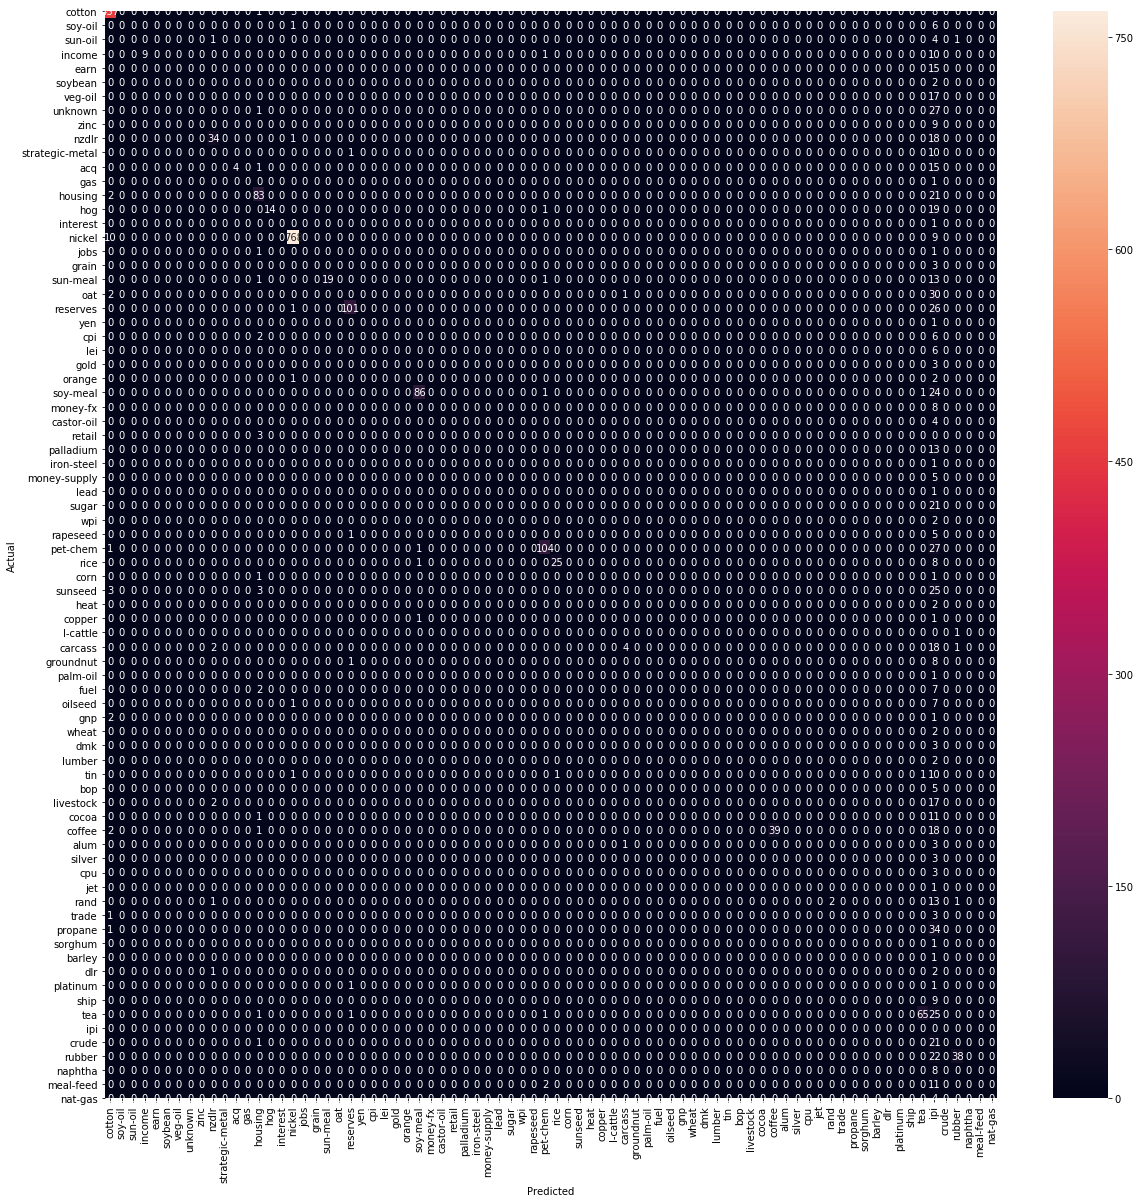

In [27]:
conf_mat = confusion_matrix(df_flat.actual, df_flat.predicted)

fig, ax = plt.subplots(figsize=(20,20))
matrix_labels = set([*df_flat.actual, *df_flat.predicted])
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=matrix_labels, yticklabels=matrix_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Classification Report

In [28]:
print(classification_report(df_flat.actual, df_flat.predicted, target_names=matrix_labels))

C:\Users\jdelrio\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jdelrio\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                 precision    recall  f1-score   support

         cotton       0.95      0.97      0.96       469
        soy-oil       0.00      0.00      0.00         7
        sun-oil       0.00      0.00      0.00         6
         income       1.00      0.45      0.62        20
           earn       0.00      0.00      0.00        15
        soybean       0.00      0.00      0.00         2
        veg-oil       0.00      0.00      0.00        17
        unknown       0.00      0.00      0.00        28
           zinc       0.00      0.00      0.00         9
          nzdlr       0.83      0.64      0.72        53
strategic-metal       0.00      0.00      0.00        11
            acq       1.00      0.20      0.33        20
            gas       0.00      0.00      0.00         1
        housing       0.81      0.78      0.79       106
            hog       1.00      0.41      0.58        34
       interest       0.00      0.00      0.00         1
         nickel       0.99    

As previously the results are dependent on the category and due to the inbalance of the train samples. It is worth noticing that some labels are not present in the test set...

### ROC Curve & AUC

First let's get all the corresponding catetories and predictions with their values. <br>
After that we'll calculate the Receiver operating characteristic (ROC) and finally the Area under the curve (AUC).

In [29]:
pd_comp = pd.DataFrame({'actual': x_te['categories'], 'predicted': te_pred})
pd_comp['predicted'] = pd_comp['predicted'].apply(lambda x: apply_threshold(x, report_value=True))

cat_actual = pd_comp['actual'].tolist()
cat_predicted = pd_comp['predicted'].apply(dict)

In [30]:
def get_score_list(tokenizer, textcat, cat_predicted, cat_actual):
    pred = []
    real = []
    
    for i, doc_cat in enumerate(cat_predicted):
        gold = cat_actual[i]
#         breakpoint()
        for label, score in doc_cat.items():
            pred.append(round(score, 2))
            if label not in gold:
                real.append(False)
            else:
                real.append(True)       # gold[label]
                
    return real, pred
    
scores_real, scores_prediction = get_score_list(nlp.tokenizer, textcat, cat_predicted, cat_actual)

In [31]:
fpr, tpr, thresholds = roc_curve(scores_real, scores_prediction)

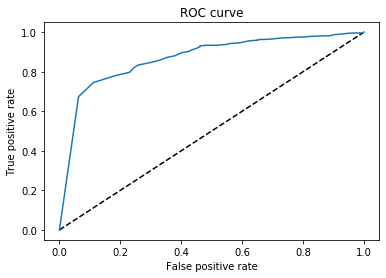

In [32]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [33]:
auc = auc(fpr, tpr)
print('AUC: {0:.3f}'.format(auc))

AUC: 0.869
